## Dimensionality Reduction
As the name says, dimensionality reduction is the idea of reducing your feature set to a much smaller number. Dimensionality reduction is often used in visualization of datasets to try and detect samples that are similar. We will cover three dimensionality reduction techniques here: 
1. t-SNE
2. PCA
3. umap

In [2]:
# Packages we will use throughout this notebook
using UMAP
using Makie
using XLSX
using VegaDatasets
using DataFrames
using MultivariateStats
using RDatasets
using StatsBase
using Statistics
using LinearAlgebra
using Plots
using ScikitLearn
using MLBase
using Distances

We will use a dataset from the VegaDatasets package. The dataset is about car specifications of over 400 car models.

In [3]:
C = DataFrame(VegaDatasets.dataset("cars"))

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower
,String,Float64?,Int64,Float64,Int64?
1,chevrolet chevelle malibu,18.0,8,307.0,130
2,buick skylark 320,15.0,8,350.0,165
3,plymouth satellite,18.0,8,318.0,150
4,amc rebel sst,16.0,8,304.0,150
5,ford torino,17.0,8,302.0,140
6,ford galaxie 500,15.0,8,429.0,198
7,chevrolet impala,14.0,8,454.0,220
8,plymouth fury iii,14.0,8,440.0,215
9,pontiac catalina,14.0,8,455.0,225


In [4]:
dropmissing!(C)
M = Matrix(C[:,2:7])
names(C)

9-element Vector{String}:
 "Name"
 "Miles_per_Gallon"
 "Cylinders"
 "Displacement"
 "Horsepower"
 "Weight_in_lbs"
 "Acceleration"
 "Year"
 "Origin"

In [5]:
car_origin = C[:,:Origin]
carmap = labelmap(car_origin) #from MLBase
uniqueids = labelencode(carmap,car_origin)

392-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 2
 1
 1
 1
 3
 1
 1
 1

### 1️⃣ PCA 
We will first center the data.

In [6]:
# center and normalize the data
data = M
data = (data .- mean(data,dims = 1))./ std(data,dims=1)

392×6 Matrix{Float64}:
 -0.697747   1.48205    1.07591    0.663285   0.619748   -1.28362
 -1.08212    1.48205    1.48683    1.57258    0.842258   -1.46485
 -0.697747   1.48205    1.18103    1.18288    0.539692   -1.64609
 -0.953992   1.48205    1.04725    1.18288    0.53616    -1.28362
 -0.82587    1.48205    1.02813    0.923085   0.554997   -1.82732
 -1.08212    1.48205    2.24177    2.42992    1.60515    -2.00855
 -1.21024    1.48205    2.48068    3.00148    1.62045    -2.37102
 -1.21024    1.48205    2.34689    2.87158    1.57101    -2.55226
 -1.21024    1.48205    2.49023    3.13138    1.70404    -2.00855
 -1.08212    1.48205    1.86908    2.22208    1.02709    -2.55226
 -1.08212    1.48205    1.80219    1.70248    0.689209   -2.00855
 -1.21024    1.48205    1.39127    1.44268    0.743365   -2.73349
 -1.08212    1.48205    1.96464    1.18288    0.922314   -2.18979
  ⋮                                                       ⋮
  0.199113   0.309571  -0.128168   0.143685  -0.0383613   0

PCA expects each column to be an observation, so we will use the transpose of the matrix.

In [7]:
# each car is now a column, PCA takes features - by - samples matrix
data'

6×392 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.697747  -1.08212   -0.697747  …   1.09597    0.583482   0.967851
  1.48205    1.48205    1.48205      -0.862911  -0.862911  -0.862911
  1.07591    1.48683    1.18103      -0.567753  -0.711097  -0.720653
  0.663285   1.57258    1.18288      -0.531795  -0.661694  -0.583754
  0.619748   0.842258   0.539692     -0.803605  -0.415097  -0.303253
 -1.28362   -1.46485   -1.64609   …  -1.4286     1.10867    1.39865

First, we will fit the model via PCA. `maxoutdim` is the output dimensions, we want it to be 2 in this case.

In [8]:
p = fit(PCA,data',maxoutdim=2)

PCA(indim = 6, outdim = 2, principalratio = 0.9194828785333571)

We can obtain the projection matrix by calling the function `projection`

In [9]:
P = projection(p)

6×2 Matrix{Float64}:
  0.398973  -0.244835
 -0.430615   0.148314
 -0.443531   0.108497
 -0.434122  -0.166158
 -0.430103   0.286095
  0.291926   0.892652

Now that we have the projection matrix, `P`, we can apply it on one car as follows:

In [10]:
P'*(data[1,:]-mean(p))

2-element Vector{Float64}:
 -2.3230016965226925
 -0.5713519642644684

Or we can transorm all the data via the transform function.

In [11]:
Yte = MultivariateStats.transform(p, data') #notice that Yte[:,1] is the same as P'*(data[1,:]-mean(p))

2×392 Matrix{Float64}:
 -2.323     -3.20196  -2.66658   -2.60214   …   1.22011  1.70921   1.86951
 -0.571352  -0.68187  -0.992744  -0.621975     -1.87471  0.632857  0.815607

We can also go back from two dimensions to 6 dimensions, via the `reconstruct` function... But this time, it will be approximate.

In [12]:
# reconstruct testing observations (approximately)
Xr = reconstruct(p, Yte)

6×392 Matrix{Float64}:
 -0.786928  -1.11055  -0.820834  …   0.945785   0.526984   0.546196
  0.91558    1.27768   1.00103      -0.803445  -0.64215   -0.684075
  0.968334   1.34619   1.075        -0.744559  -0.689425  -0.740696
  1.1034     1.50334   1.32257      -0.218179  -0.847159  -0.947116
  0.835669   1.18209   0.862883     -1.06112   -0.554079  -0.570742
 -1.18816   -1.54341  -1.66462   …  -1.31728    1.06388    1.27381

In [13]:
norm(Xr-data') # this won't be zero

13.74384105556901

Finally, we will generate a scatter plot of the cars:

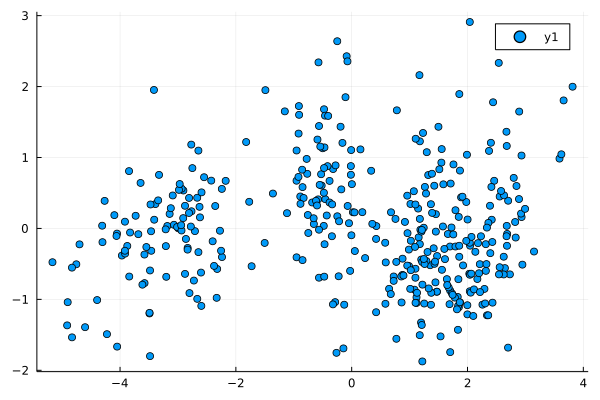

In [14]:
Plots.scatter(Yte[1,:],Yte[2,:])

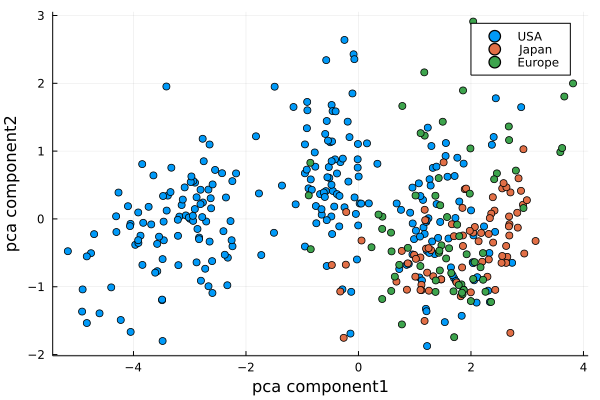

In [15]:
Plots.scatter(Yte[1,car_origin.=="USA"],Yte[2,car_origin.=="USA"],color=1,label="USA")
Plots.xlabel!("pca component1")
Plots.ylabel!("pca component2")
Plots.scatter!(Yte[1,car_origin.=="Japan"],Yte[2,car_origin.=="Japan"],color=2,label="Japan")
Plots.scatter!(Yte[1,car_origin.=="Europe"],Yte[2,car_origin.=="Europe"],color=3,label="Europe")

This is interesting! There seems to be three main clusters with cars from the US dominating two clusters.

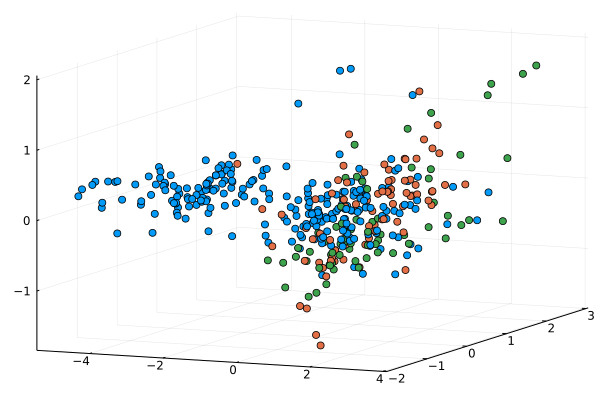

In [16]:
p = fit(PCA,data',maxoutdim=3)
Yte = MultivariateStats.transform(p, data')
scatter3d(Yte[1,:],Yte[2,:],Yte[3,:],color=uniqueids,legend=false)

This is a 3d plot, but eventhough you can set the camera view, you won't be able to move the 3d plot around. Let's use another package for this purpose. We will use `Mackie`.

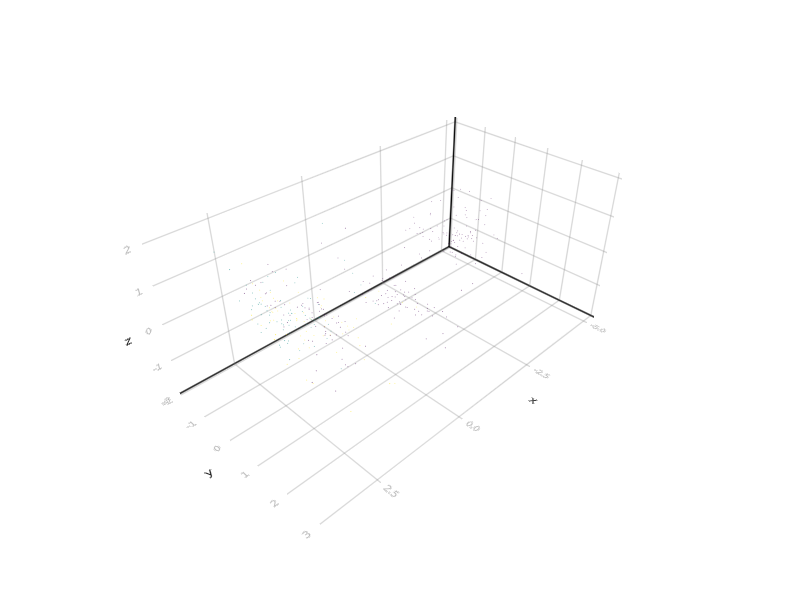

┌ Info: Makie/Makie is caching fonts, this may take a while. Needed only on first run!
└ @ Makie C:\Users\CaioSainVallio\.julia\packages\Makie\NL7Xw\src\utilities\texture_atlas.jl:113


In [18]:
using GLMakie
scene = Makie.scatter(Yte[1,:],Yte[2,:],Yte[3,:],color=uniqueids)

And now, you can call `display(scene)` to create an interactive gui.

In [19]:
display(scene)

GLMakie.Screen(...)

### 2️⃣ t-SNE
The next method we will use for dimensionality reduction is t-SNE. There are multiple ways you can call t-SNE from julia. Check out this notebook: https://github.com/nassarhuda/JuliaTutorials/blob/master/TSNE/TSNE.ipynb. But we will take this opportunity to try out something new... Call a function from the Scikit learn python package. This makes use of the package `ScikitLearn`.

C:\Users\CaioSainVallio\.julia\conda\3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\CaioSainVallio\.julia\conda\3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


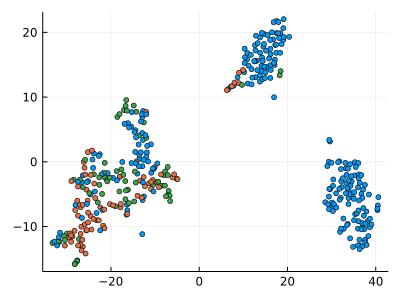

In [23]:
@sk_import manifold : TSNE
tfn = TSNE(n_components=2) #,perplexity=20.0,early_exaggeration=50)
Y2 = tfn.fit_transform(data);
Plots.scatter(Y2[:,1],Y2[:,2],color=uniqueids,legend=false,size=(400,300),markersize=3)

This is interesting! The same patterns appears to hold here too. 

### 3️⃣ Next, UMAP
This will be our final dimensionality reduction method and we will use the package `UMAP` for it.

In [21]:
L = cor(data,data,dims=2)
embedding = umap(L, 2)

2×392 Matrix{Float64}:
 -8.11282   -8.95738   -8.18438  …  5.91849   1.37529  5.19142  5.32984
 -0.885802  -0.966958  -1.34786     2.28248  -3.03815  3.36232  3.14285

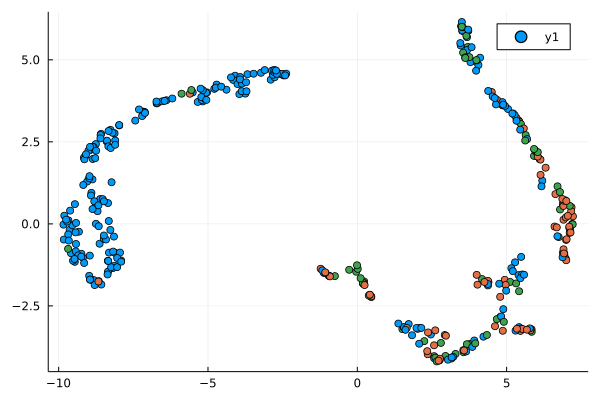

In [22]:
Plots.scatter(embedding[1,:],embedding[2,:],color=uniqueids)

For UMAP, we can create distances between every pair of observations differently, if we choose to. But even with both choices, we will see that UMAP generates a very similar pattern to what we have observed with t-SNE and PCA.

In [24]:
L = pairwise(Euclidean(), data, data,dims=1) 
embedding = umap(-L, 2)

2×392 Matrix{Float64}:
 -6.50034  -8.77031   -6.5921  -6.70123  …   4.77351   2.81031   2.6521
  3.19557   0.693445   2.6637   2.69256     -5.07503  -2.43907  -2.5571

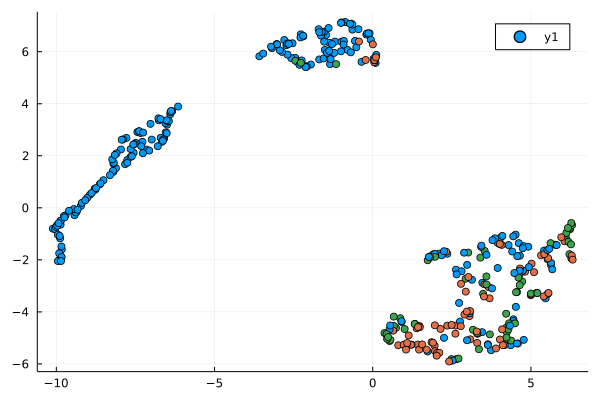

In [25]:
Plots.scatter(embedding[1,:],embedding[2,:],color=uniqueids)

# Finally...
After finishing this notebook, you should be able to:
- [ ] apply tsne on your data
- [ ] apply umap on your data
- [ ] apply pca on your data
- [ ] generate a 3d plot
- [ ] call a function from Python's ScikitLearn

# 🥳 One cool finding

All dimensionality reduction techniques we used seemed to agree on that European and Japanese cars seem to be similar in specifications where as American cars seem to form their own two clusters based on their specifications.

Blue are American cars. Green and orange are Japanese and European.

<img src="data/0401.png" width="400">
